##Modelo TCN para todo filtro

Subir Dataset

In [ ]:
import torch
import numpy as np

from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/kaspix_universal_rack.pt'
data = torch.load(data_path, weights_only=False)

# Ver composición
print("Composición del Dataset")
print(f"Claves disponibles: {data.keys()}")
print(f"N de muestras: {len(data['x'])}")

# Ver dimensiones de una muestra
sample_x = data['x'][0]
sample_y = data['y'][0]

print("\n Dimensiones de una muestra")
print(f"Audio entrada: {sample_x['audio_in'].shape}") # Debería ser (n_samples,)
print(f"Audio salida: {sample_y.shape}")            # Debería ser (n_samples,)
print(f"Cantidad de Knobs: {len(sample_x['knobs'])}")
print(f"Nombres originales de los Knobs: {sample_x['original_names']}")
print(f"ID de Topología (Filtro): {sample_x['topology_id']}")
print("Lista de archivos fuentes en el dataset:")
for i, m in enumerate(data['meta']):
    print(f"ID {i}: {m['source']}")

mid_idx = len(data['x']) // 2
sample_mid = data['x'][mid_idx]
print(f"\n--- Análisis Muestra del Medio ({mid_idx}) ---")
print(f"ID de Topología: {sample_mid['topology_id']}")
print(f"Nombres originales: {sample_mid['original_names']}")

Mounted at /content/drive
Composición del Dataset
Claves disponibles: dict_keys(['x', 'y', 'meta', 'max_knobs', 'description'])
N de muestras: 99371

 Dimensiones de una muestra
Audio entrada: (960,)
Audio salida: (960,)
Cantidad de Knobs: 5
Nombres originales de los Knobs: ['R_gain', 'C_cut', 'V_bias']
ID de Topología (Filtro): 0
Lista de archivos fuentes en el dataset:
ID 0: kaspix_training_data_v4 (1).pt
ID 1: kaspix_training_data_hpf (1).pt
ID 2: bpf_cascade_30k.pt
ID 3: kaspix_training_data_bsf.pt

--- Análisis Muestra del Medio (49685) ---
ID de Topología: 2
Nombres originales: ['R_gain', 'C_hp', 'R_lpf', 'C_lpf', 'R_load']


DataLoader

In [ ]:
import numpy as np
import torch
from IPython.testing import test
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

class UniversalKaspixDataset(Dataset):
    def __init__(self, data_path):
        print("Cargando archivo maestro en memoria...")
        data = torch.load(data_path, weights_only=False)

        # 1. Audios (Entrada y Salida)
        # Convertimos las listas de diccionarios en tensores [N, 1, 960]
        print("Procesando señales de audio...")
        self.x_audio = torch.stack([
            torch.from_numpy(np.array(item['audio_in'], dtype=np.float32)).unsqueeze(0)
            for item in data['x']
        ])
        self.y = torch.stack([
            torch.from_numpy(np.array(item, dtype=np.float32)).unsqueeze(0)
            for item in data['y']
        ])

        # 2. Vector de Control (9 columnas)
        # Columnas 0-3: ID del Filtro (One-Hot)
        # Columnas 4-8: Parámetros físicos (Knobs)
        print("Construyendo matriz de control universal...")
        num_samples = len(self.x_audio)
        self.x_knobs = torch.zeros(num_samples, 9)

        for i, item in enumerate(data['x']):
            # A) Inyectar los 5 Knobs (columnas 4 a 8)
            # Como el dataset es "Zero-Padded", siempre hay 5 valores
            k_values = item['knobs']
            self.x_knobs[i, 4:] = torch.tensor(k_values, dtype=torch.float32)

            # B) Inyectar el Identificador (columnas 0 a 3)
            # Usamos el topology_id que extrajiste (0:LP, 1:HP, 2:BP, 3:BS)
            t_id = item['topology_id']
            if t_id < 4:
                self.x_knobs[i, t_id] = 1.0

        # 3. Normalización Global de los Knobs (Solo columnas 4-8)
        # Esto es vital para que la red no se sature con valores de resistencias altos
        print("Normalizando parámetros físicos...")
        self.knob_mean = self.x_knobs[:, 4:].mean(dim=0, keepdim=True)
        self.knob_std = self.x_knobs[:, 4:].std(dim=0, keepdim=True)
        self.x_knobs[:, 4:] = (self.x_knobs[:, 4:] - self.knob_mean) / (self.knob_std + 1e-8)

        print(f"\n ¡Dataset Universal cargado con éxito!")
        print(f"Total: {num_samples} muestras de 4 tipos de filtros.")

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # Retorna: Audio de entrada, Vector de control (9), Audio de salida
        return self.x_audio[idx], self.x_knobs[idx], self.y[idx]

In [ ]:
# 1. Definimos los tamaños de partición (90% entrenamiento, 10% validación)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_path = 'kaspix_universal_model.pth'

# 1. Cargar Dataset (Usa la clase UniversalKaspixDataset que definimos antes)
full_ds = UniversalKaspixDataset(data_path)
train_size = int(0.9 * len(full_ds))
val_size = len(full_ds) - train_size

# 2. Realizamos el split aleatorio
train_dataset, val_dataset = random_split(full_ds, [train_size, val_size])

# 3. Creamos los DataLoaders
# Batch size de 128 es un buen equilibrio entre velocidad y estabilidad
train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,      # CRÍTICO: Mezclar LP, HP, BP y BS en cada batch
    num_workers=0,     # Paralelismo para carga de datos
    pin_memory=True    # Acelera la transferencia a la GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f" DataLoaders listos:")
print(f" - Batches de entrenamiento: {len(train_loader)}")
print(f" - Batches de validación: {len(val_loader)}")

Cargando archivo maestro en memoria...
Procesando señales de audio...
Construyendo matriz de control universal...
Normalizando parámetros físicos...

 ¡Dataset Universal cargado con éxito!
Total: 99371 muestras de 4 tipos de filtros.
 DataLoaders listos:
 - Batches de entrenamiento: 699
 - Batches de validación: 78


Arquitectura

> FiLM Multi-Modo: en cada una de las 12 capas, los controladores modulan la señal. Si los bits de ID indican modelo x, las capas FiLM ajustan los pesos para crear la cancelación de fase correcta.



> Dilatación profunda: con 12 capas hay una dilatación de 8192, pero con crecimiento actual se cubre suficiente tiempo para que el filtro Pasa Bajo tenga graves definidos y el Rechaza Banda tengaa una muesca estrecha.



> Normalización de Grupo: al usar GroupNorm de ayuda a la red a mantener estabilidad aunque se cambie bruscamente un filtro a otro en el mismo batch.








In [ ]:
import torch
import torch.nn as nn

class FiLM(nn.Module):
    def __init__(self, channels, knob_dim):
        super().__init__()
        # Genera un factor de escala (gamma) y un desplazamiento (beta) para cada canal
        self.gen = nn.Linear(knob_dim, channels * 2)

    def forward(self, x, knobs):
        # knobs tiene dimensión [Batch, 9] (4 IDs + 5 Parámetros)
        params = self.gen(knobs).unsqueeze(2)
        gamma, beta = torch.chunk(params, 2, dim=1)
        return x * gamma + beta

class TCN(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, dilation, knob_dim):
        super().__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_ch, out_ch, kernel_size,
                              padding=self.padding, dilation=dilation)
        self.film = FiLM(out_ch, knob_dim)
        self.act = nn.PReLU()
        self.norm = nn.GroupNorm(1, out_ch)
        self.res = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, knobs):
        res = self.res(x)
        x = self.conv(x)
        if self.padding > 0:
            x = x[:, :, :-self.padding]
        x = self.film(x, knobs) # Aquí es donde los 4 bits de ID dicen qué hacer
        x = self.norm(x)
        return self.act(x) + res

class KaspixTCN(nn.Module):
    def __init__(self, num_knobs=9):
        super().__init__()
        self.channels = 128
        self.num_layers = 12
        self.layers = nn.ModuleList()

        self.layers.append(TCN(1, self.channels, 3, 1, num_knobs))
        for i in range(1, self.num_layers):
            dilation = 2 ** i
            self.layers.append(TCN(self.channels, self.channels, 3, dilation, num_knobs))

        self.output = nn.Conv1d(self.channels, 1, kernel_size=1, bias=False)

    def forward(self, audio, knobs):
        x = audio
        for layer in self.layers:
            x = layer(x, knobs)
        return self.output(x)

Entrenamiento inicial

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import numpy as np

# --- 1. Métricas de Audio ---
def calculate_esr(pred, target):
    return torch.sum((target - pred)**2) / (torch.sum(target**2) + 1e-9)

def calculate_lsd(pred, true, fs=44100):
    Y_true = torch.fft.rfft(true, dim=-1).abs() + 1e-8
    Y_pred = torch.fft.rfft(pred, dim=-1).abs() + 1e-8
    log_diff = torch.log10(Y_true ** 2) - torch.log10(Y_pred ** 2)
    lsd = torch.sqrt(torch.mean(log_diff ** 2, dim=-1))
    return torch.mean(lsd)

# --- 2. Configuración del Modelo Universal ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_path = 'best_kaspix_universal_rack.pth'

# Detectamos dimensiones (deberían ser 9: 4 IDs + 5 Knobs)
num_inputs_control = full_ds.x_knobs.shape[1]
print(f'Configuración detectada: {num_inputs_control} señales de control.')

# Instanciamos la arquitectura de 128 canales
model = KaspixTCN(num_knobs=num_inputs_control).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=4)
criterion = nn.MSELoss()

# --- 3. Bucle de Entrenamiento ---
print(f" Iniciando entrenamiento UNIVERSAL en {device}...")

best_score = float('inf')
patience_counter = 0
patience = 8  # Un poco más de paciencia para 4 filtros simultáneos
epochs = 50    # Más épocas para asegurar convergencia de las 4 topologías

for epoch in range(epochs):
    model.train()
    train_loss = 0
    pbar = tqdm(train_loader, desc=f"Época {epoch+1}/{epochs}", leave=False)

    for x_audio, x_knobs, y_true in pbar:
        x_audio, x_knobs, y_true = x_audio.to(device), x_knobs.to(device), y_true.to(device)

        optimizer.zero_grad()
        y_pred = model(x_audio, x_knobs)

        # Pérdida híbrida: MSE tiempo + 0.1 * ESR forma
        loss_mse = criterion(y_pred, y_true)
        loss_esr = calculate_esr(y_pred, y_true)
        loss = loss_mse + (0.1 * loss_esr)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()

        if pbar.n % 10 == 0:
            with torch.no_grad():
                esr_val = calculate_esr(y_pred, y_true)
                lsd_val = calculate_lsd(y_pred, y_true)
            pbar.set_postfix(loss=f"{loss.item():.5f}", esr=f"{esr_val.item():.4f}", lsd=f"{lsd_val.item():.3f}")

    # --- 4. Fase de Validación ---
    model.eval()
    val_mse, val_esr, val_lsd = 0, 0, 0

    with torch.no_grad():
        for x_a, x_k, y_t in val_loader:
            x_a, x_k, y_t = x_a.to(device), x_k.to(device), y_t.to(device)
            y_p = model(x_a, x_k)
            val_mse += criterion(y_p, y_t).item()
            val_esr += calculate_esr(y_p, y_t).item()
            val_lsd += calculate_lsd(y_p, y_t).item()

    avg_mse = val_mse / len(val_loader)
    avg_esr = val_esr / len(val_loader)
    avg_lsd = val_lsd / len(val_loader)

    scheduler.step(avg_mse)

    # Score combinado para el Rack
    score_actual = avg_esr + (avg_lsd / 4)

    print(f"\n Época {epoch+1}: MSE: {avg_mse:.6f} | ESR: {avg_esr:.6f} | LSD: {avg_lsd:.4f}")

    # --- 5. Guardado del mejor modelo ---
    if score_actual < best_score:
        best_score = score_actual
        patience_counter = 0
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'val_esr': avg_esr,
            'val_lsd': avg_lsd,
            'knob_mean': full_ds.knob_mean,
            'knob_std': full_ds.knob_std
            }, checkpoint_path)
        print(f" ¡Nuevo Récord Universal! Score: {score_actual:.6f}")
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping activado. El Rack ha convergido.")
        break

print(f" Entrenamiento finalizado. Mejor Score Universal: {best_score:.6f}")

Configuración detectada: 9 señales de control.
 Iniciando entrenamiento UNIVERSAL en cuda...


Época 1/50:   0%|          | 0/699 [00:00<?, ?it/s]


 Época 1: MSE: 0.006649 | ESR: 0.143888 | LSD: 0.6902
 ¡Nuevo Récord Universal! Score: 0.316427


Época 2/50:   0%|          | 0/699 [00:00<?, ?it/s]


 Época 2: MSE: 0.004852 | ESR: 0.105020 | LSD: 0.6277
 ¡Nuevo Récord Universal! Score: 0.261954


Época 3/50:   0%|          | 0/699 [00:00<?, ?it/s]


 Época 3: MSE: 0.003802 | ESR: 0.082575 | LSD: 0.6004
 ¡Nuevo Récord Universal! Score: 0.232679


Época 4/50:   0%|          | 0/699 [00:00<?, ?it/s]


 Época 4: MSE: 0.002109 | ESR: 0.045644 | LSD: 0.5747
 ¡Nuevo Récord Universal! Score: 0.189317


Época 5/50:   0%|          | 0/699 [00:00<?, ?it/s]


 Época 5: MSE: 0.001575 | ESR: 0.034093 | LSD: 0.5493
 ¡Nuevo Récord Universal! Score: 0.171414


Época 6/50:   0%|          | 0/699 [00:00<?, ?it/s]


 Época 6: MSE: 0.001297 | ESR: 0.028058 | LSD: 0.5435
 ¡Nuevo Récord Universal! Score: 0.163930


Época 7/50:   0%|          | 0/699 [00:00<?, ?it/s]


 Época 7: MSE: 0.001116 | ESR: 0.024201 | LSD: 0.5346
 ¡Nuevo Récord Universal! Score: 0.157859


Época 8/50:   0%|          | 0/699 [00:00<?, ?it/s]


 Época 8: MSE: 0.000975 | ESR: 0.021166 | LSD: 0.5155
 ¡Nuevo Récord Universal! Score: 0.150052


Época 9/50:   0%|          | 0/699 [00:00<?, ?it/s]


 Época 9: MSE: 0.000950 | ESR: 0.020660 | LSD: 0.5081
 ¡Nuevo Récord Universal! Score: 0.147682


Época 10/50:   0%|          | 0/699 [00:00<?, ?it/s]


 Época 10: MSE: 0.000892 | ESR: 0.019372 | LSD: 0.5091
 ¡Nuevo Récord Universal! Score: 0.146636


Época 11/50:   0%|          | 0/699 [00:00<?, ?it/s]


 Época 11: MSE: 0.000821 | ESR: 0.017861 | LSD: 0.5070
 ¡Nuevo Récord Universal! Score: 0.144606


Época 12/50:   0%|          | 0/699 [00:00<?, ?it/s]


 Época 12: MSE: 0.000744 | ESR: 0.016201 | LSD: 0.5060
 ¡Nuevo Récord Universal! Score: 0.142707


Época 13/50:   0%|          | 0/699 [00:00<?, ?it/s]


 Época 13: MSE: 0.000685 | ESR: 0.014974 | LSD: 0.5047
 ¡Nuevo Récord Universal! Score: 0.141157


Época 14/50:   0%|          | 0/699 [00:00<?, ?it/s]


 Época 14: MSE: 0.000719 | ESR: 0.015679 | LSD: 0.5041


Época 15/50:   0%|          | 0/699 [00:00<?, ?it/s]


 Época 15: MSE: 0.000594 | ESR: 0.012984 | LSD: 0.5179


Época 16/50:   0%|          | 0/699 [00:00<?, ?it/s]


 Época 16: MSE: 0.000532 | ESR: 0.011568 | LSD: 0.5224


Época 17/50:   0%|          | 0/699 [00:00<?, ?it/s]


 Época 17: MSE: 0.000453 | ESR: 0.009875 | LSD: 0.5181
 ¡Nuevo Récord Universal! Score: 0.139395


Época 18/50:   0%|          | 0/699 [00:00<?, ?it/s]


 Época 18: MSE: 0.000626 | ESR: 0.013646 | LSD: 0.5244


Época 19/50:   0%|          | 0/699 [00:00<?, ?it/s]


 Época 19: MSE: 0.000449 | ESR: 0.009718 | LSD: 0.5243


Época 20/50:   0%|          | 0/699 [00:00<?, ?it/s]


 Época 20: MSE: 0.000417 | ESR: 0.009073 | LSD: 0.5205
 ¡Nuevo Récord Universal! Score: 0.139208


Época 21/50:   0%|          | 0/699 [00:00<?, ?it/s]


 Época 21: MSE: 0.000371 | ESR: 0.008095 | LSD: 0.5243
 ¡Nuevo Récord Universal! Score: 0.139162


Época 22/50:   0%|          | 0/699 [00:00<?, ?it/s]


 Época 22: MSE: 0.000770 | ESR: 0.016786 | LSD: 0.5298


Época 23/50:   0%|          | 0/699 [00:00<?, ?it/s]


 Época 23: MSE: 0.000328 | ESR: 0.007123 | LSD: 0.5256
 ¡Nuevo Récord Universal! Score: 0.138532


Época 24/50:   0%|          | 0/699 [00:00<?, ?it/s]

Gráficos

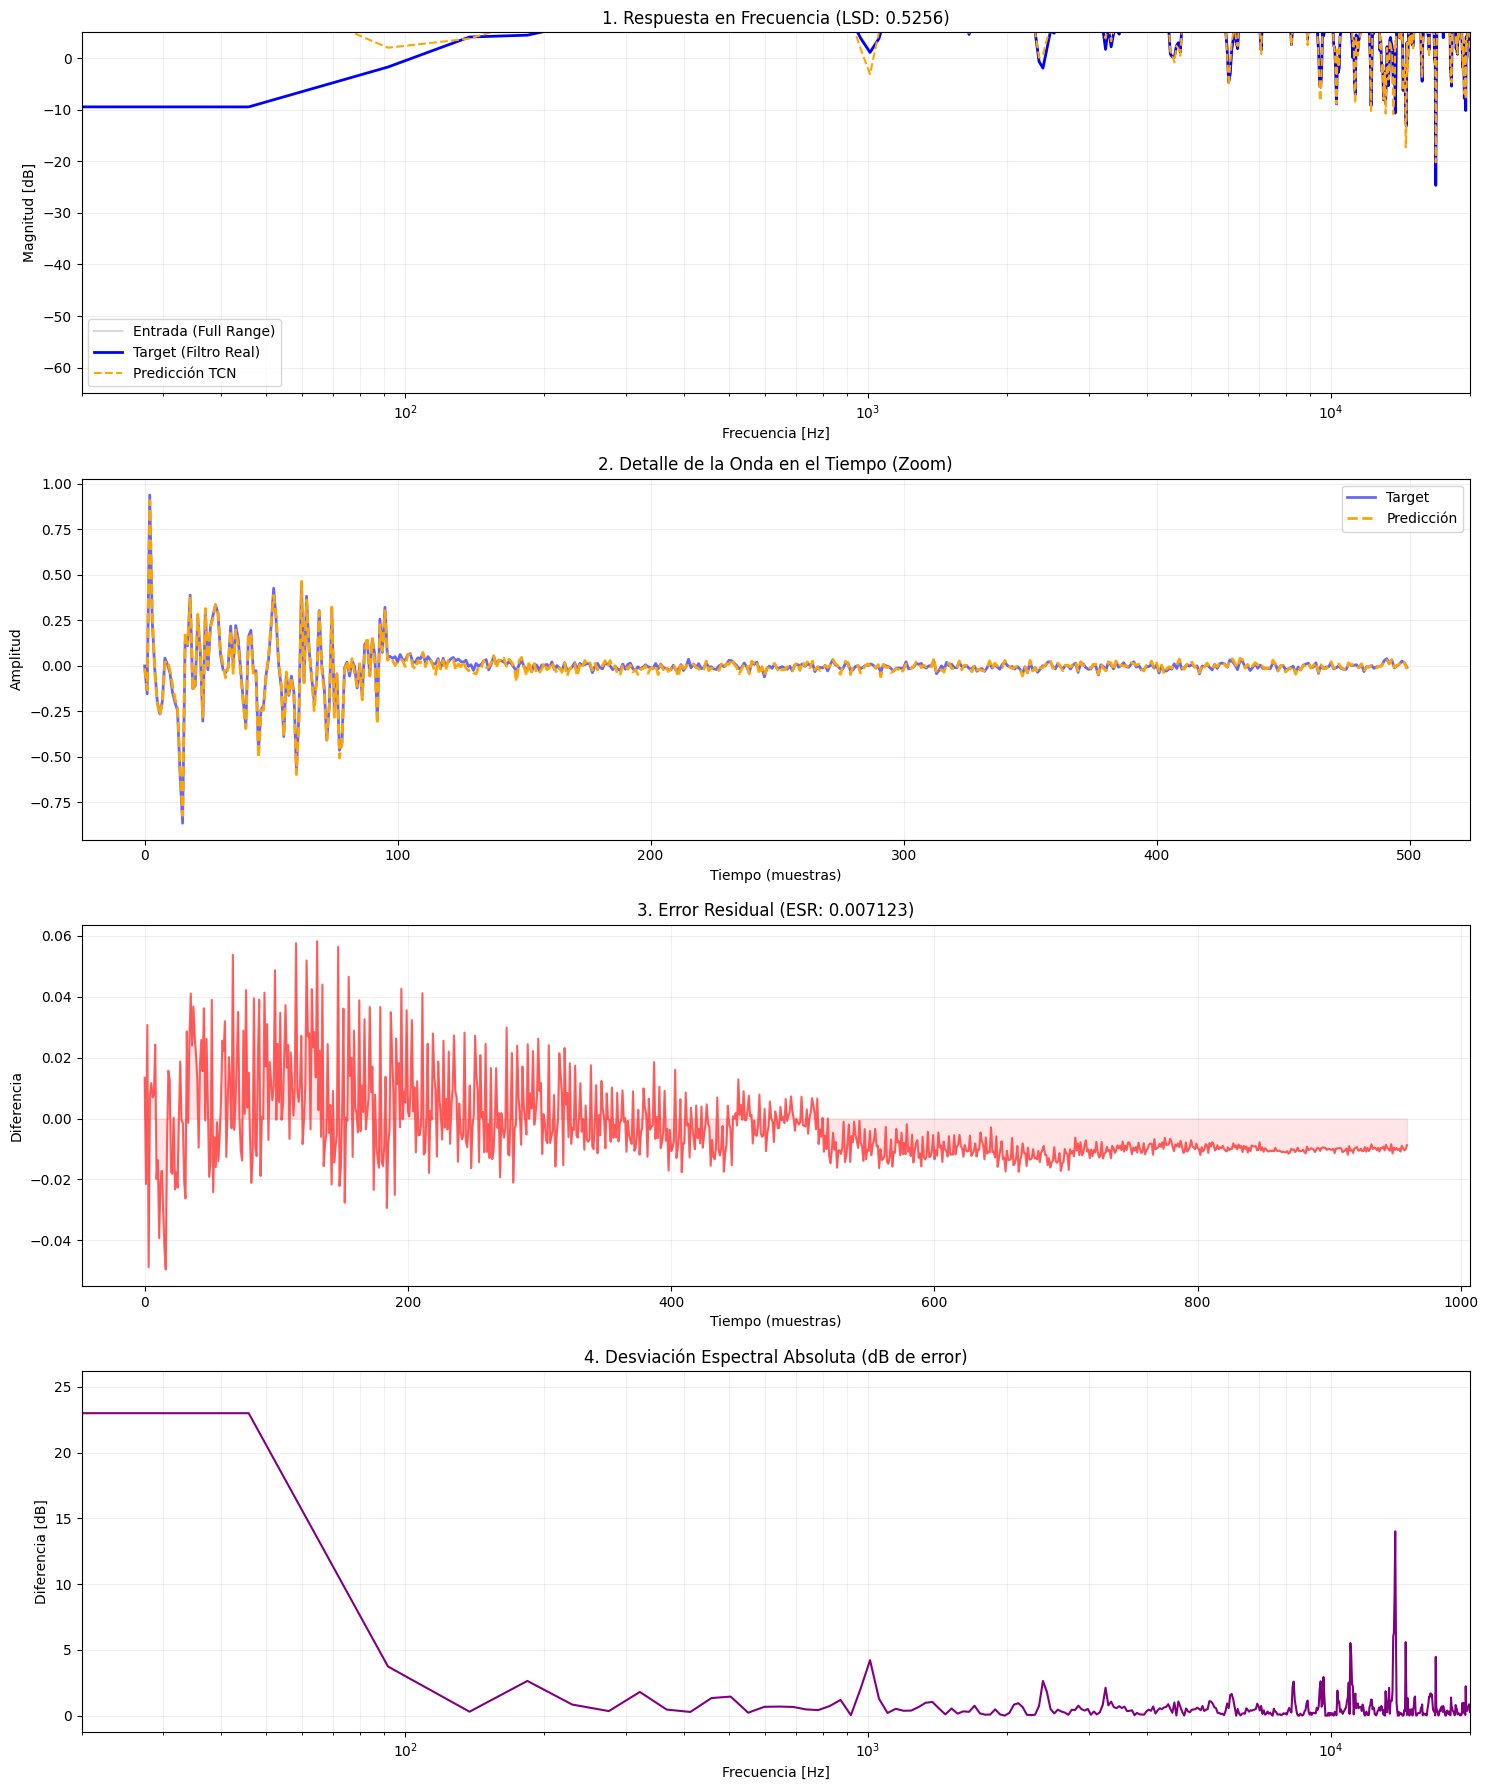

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 1. Preparar el modelo y cargar pesos
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_inputs_knobs = val_dataset.dataset.x_knobs.shape[1]

model = KaspixTCN(num_knobs=num_inputs_knobs).to(device)
checkpoint = torch.load('best_kaspix_universal_rack.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# 2. Extraer una muestra de validación
sample_idx = 748
x_audio, x_knobs, y_true = val_dataset[sample_idx]
x_audio_t = x_audio.unsqueeze(0).to(device)
x_knobs_t = x_knobs.unsqueeze(0).to(device)

with torch.no_grad():
    y_pred_t = model(x_audio_t, x_knobs_t)

# 3. Conversión a numpy para visualización
y_true_np = y_true.squeeze().cpu().numpy()
y_pred_np = y_pred_t.squeeze().cpu().numpy()
x_in_np = x_audio.squeeze().cpu().numpy()

# --- DASHBOARD DE RESULTADOS ---
plt.figure(figsize=(15, 18))

# A. RESPUESTA EN FRECUENCIA (FFT)
plt.subplot(4, 1, 1)
def get_magnitude_db(sig):
    return 20 * np.log10(np.abs(np.fft.rfft(sig)) + 1e-8)

freqs = np.fft.rfftfreq(len(y_true_np), 1/44100)
plt.plot(freqs, get_magnitude_db(x_in_np), color='gray', alpha=0.3, label='Entrada (Full Range)')
plt.plot(freqs, get_magnitude_db(y_true_np), color='blue', lw=2, label='Target (Filtro Real)')
plt.plot(freqs, get_magnitude_db(y_pred_np), color='orange', ls='--', label='Predicción TCN')
plt.xscale('log')
plt.xlim(20, 20000)
plt.ylim(-65, 5)
plt.title(f"1. Respuesta en Frecuencia (LSD: {checkpoint.get('val_lsd', 0):.4f})")
plt.ylabel("Magnitud [dB]")
plt.xlabel("Frecuencia [Hz]")
plt.legend()
plt.grid(True, which="both", alpha=0.2)

# B. ZOOM FORMA DE ONDA (Tiempo)
plt.subplot(4, 1, 2)
# Mostramos un fragmento central para ver la fase y amplitud
plt.plot(y_true_np[:500], label='Target', color='blue', alpha=0.6, lw=2)
plt.plot(y_pred_np[:500], label='Predicción', color='orange', ls='--', lw=2)
plt.title("2. Detalle de la Onda en el Tiempo (Zoom)")
plt.xlabel("Tiempo (muestras)")
plt.ylabel("Amplitud")
plt.legend()
plt.grid(True, alpha=0.2)

# C. ERROR RESIDUAL
plt.subplot(4, 1, 3)
error = y_true_np - y_pred_np
plt.plot(error, color='red', alpha=0.6)
plt.title(f"3. Error Residual (ESR: {checkpoint.get('val_esr', 0):.6f})")
plt.fill_between(range(len(error)), error, color='red', alpha=0.1)
plt.xlabel("Tiempo (muestras)")
plt.ylabel("Diferencia")
plt.grid(True, alpha=0.2)

# D. ERROR POR FRECUENCIA
plt.subplot(4, 1, 4)
diff_db = np.abs(get_magnitude_db(y_true_np) - get_magnitude_db(y_pred_np))
plt.plot(freqs, diff_db, color='purple')
plt.xscale('log')
plt.xlim(20, 20000)
plt.title("4. Desviación Espectral Absoluta (dB de error)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Diferencia [dB]")
plt.grid(True, which="both", alpha=0.2)

plt.tight_layout()
plt.show()

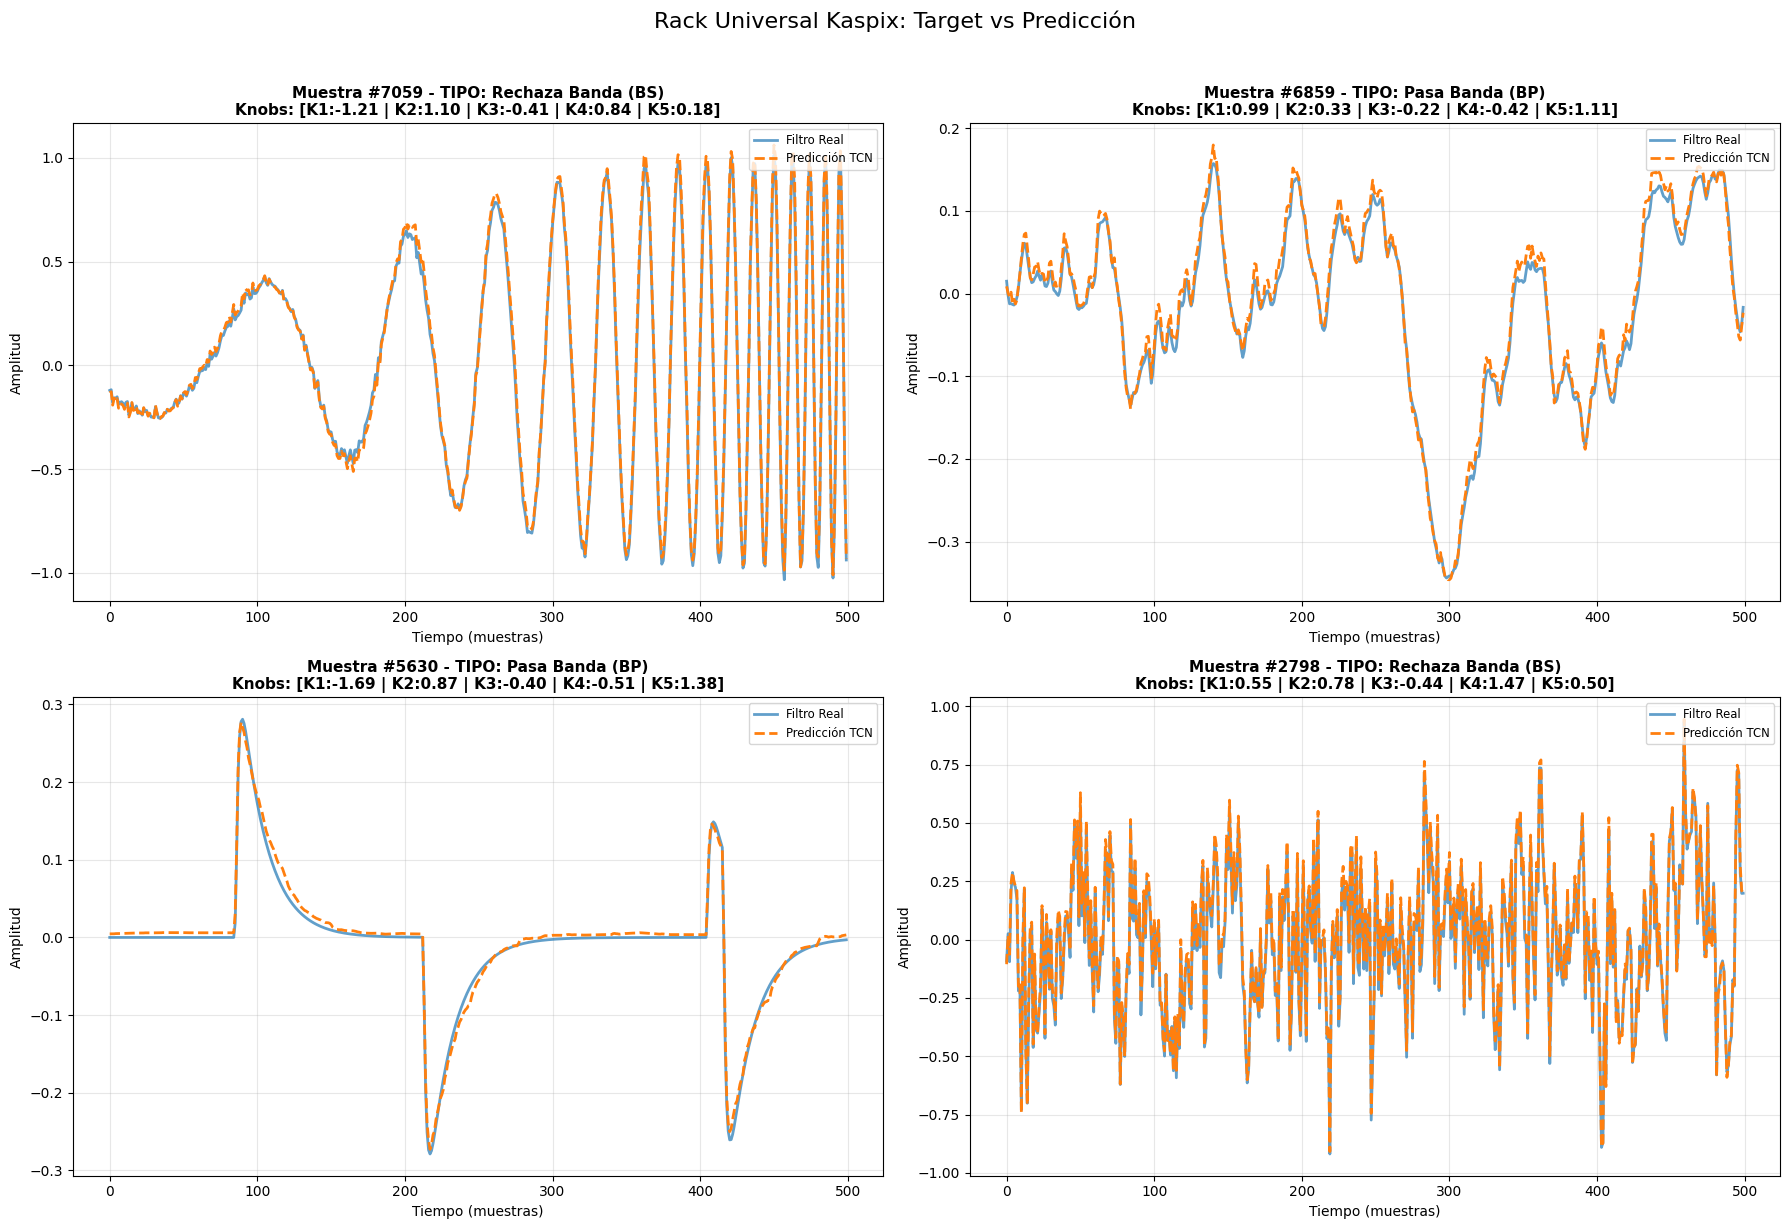

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

def visualizar_comparativa_universal(model, dataset, device):
    model.eval()
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.flatten()
    plt.subplots_adjust(hspace=0.4, wspace=0.2)

    # Diccionario para mapear el ID al nombre del filtro
    nombres_filtros = {0: "Pasa Bajo (LP)", 1: "Pasa Alto (HP)", 2: "Pasa Banda (BP)", 3: "Rechaza Banda (BS)"}

    # Seleccionamos 4 índices aleatorios
    indices = random.sample(range(len(dataset)), 4)

    with torch.no_grad():
        for i, idx in enumerate(indices):
            # 1. Extraer datos
            x_audio, x_knobs, y_true = dataset[idx]

            # 2. Preparar Tensores
            x_audio_t = x_audio.unsqueeze(0).to(device)
            x_knobs_t = x_knobs.unsqueeze(0).to(device)

            # 3. Inferencia
            y_pred_t = model(x_audio_t, x_knobs_t)

            # 4. Pasar a Numpy
            y_true_np = y_true.squeeze().cpu().numpy()
            y_pred_np = y_pred_t.squeeze().cpu().numpy()
            knobs_vals = x_knobs.cpu().numpy()

            # --- LÓGICA DE IDENTIFICACIÓN ---
            # Los primeros 4 valores son el One-Hot ID. El índice del valor '1' nos dice el tipo.
            tipo_id = np.argmax(knobs_vals[:4])
            nombre_filtro = nombres_filtros.get(tipo_id, "Desconocido")

            # Los valores físicos de los knobs están del índice 4 en adelante
            solo_knobs = knobs_vals[4:]
            # --------------------------------

            # 5. Graficar Forma de Onda
            ax = axes[i]
            start, end = 300, 800
            ax.plot(y_true_np[start:end], label='Filtro Real', color='#1f77b4', lw=2, alpha=0.7)
            ax.plot(y_pred_np[start:end], label='Predicción TCN', color='#ff7f0e', ls='--', lw=2)

            # Formatear etiquetas de los Knobs físicos
            knobs_label = " | ".join([f"K{j+1}:{v:.2f}" for j, v in enumerate(solo_knobs)])

            # Título dinámico que incluye el tipo de filtro
            ax.set_title(f"Muestra #{idx} - TIPO: {nombre_filtro}\nKnobs: [{knobs_label}]", fontsize=11, fontweight='bold')
            ax.set_xlabel("Tiempo (muestras)")
            ax.set_ylabel("Amplitud")
            ax.legend(loc='upper right', fontsize='small')
            ax.grid(True, alpha=0.3)

    plt.suptitle("Rack Universal Kaspix: Target vs Predicción", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Ejecutar la visualización
visualizar_comparativa_universal(model, val_dataset, device)